In [2]:
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# path = r'dec7_data' # use your path
# all_files = glob.glob(path + "/*.csv")

# li = []

# for filename in all_files:
#     df = pd.read_csv(filename, index_col=None, header=0)
#     li.append(df)

# data = pd.concat(li, axis=0, ignore_index=True)

data = pd.read_csv("combined_with_lambda2.csv", index_col=None, header=0)

clique_cycle_data = pd.read_csv("clique_cycle_delay5.csv", index_col=None, header=0)

In [261]:
data

,Unnamed: 0,graph,n,prc,phase_length,delay,initial_positions,converged,steps_to_converge,repeated,steps_to_repeat,lambda2,method
0,0,pchord,2,x,10,0,random,1,9.0,0,NaN,2.000000,base
1,1,pchord,2,x,10,0,random,1,1.0,0,NaN,2.000000,base
2,2,pchord,2,x,10,0,random,1,15.0,0,NaN,2.000000,base
3,3,pchord,2,x,10,0,random,1,11.0,0,NaN,2.000000,base
4,4,pchord,2,x,10,0,random,1,5.0,0,NaN,2.000000,base
...,...,...,...,...,...,...,...,...,...,...,...,...,...
33995,33995,dumbbell,58,x,10,0,random,0,NaN,1,29.0,0.064651,base
33996,33996,dumbbell,58,x,10,0,random,0,NaN,1,38.0,0.064651,base
33997,33997,dumbbell,58,x,10,0,random,1,11.0,0,NaN,0.064651,base
33998,33998,dumbbell,58,x,10,0,random,0,NaN,1,109.0,0.064651,base


In [8]:
data_ag = data.groupby(['n', 'graph', 'prc', 'delay', 'method', 'lambda2']).agg(
    converged_sum = ('converged', np.sum),
    converged_count = ('converged', "count"),
    convergence_time = ('steps_to_converge', "mean"),
    repeat_time = ('steps_to_repeat', "mean"),
    )
data_ag["percent_converged"] = data_ag["converged_sum"]/data_ag["converged_count"]
data_ag = data_ag.reset_index()
data_ag = data_ag[data_ag["n"] > 0]
data_ag = data_ag[data_ag['method'] != "constrained"]
data_ag

,n,graph,prc,delay,method,lambda2,converged_sum,converged_count,convergence_time,repeat_time,percent_converged
0,1,complete,x,0,base,0.000000,100,100,5.580000,10.000000,1.00
1,1,cycle,x,0,base,0.000000,100,100,5.700000,10.000000,1.00
2,2,complete,optimal,5,delay,2.000000,100,100,5.500000,10.000000,1.00
3,2,complete,x,0,base,2.000000,100,100,5.950000,10.000000,1.00
5,2,cycle,optimal,5,delay,2.000000,100,100,5.230000,10.000000,1.00
...,...,...,...,...,...,...,...,...,...,...,...
335,54,dumbbell,x,0,base,0.069130,67,100,11.134328,49.818182,0.67
336,56,dumbbell,optimal,5,delay,0.066815,100,100,9.430000,NaN,1.00
337,56,dumbbell,x,0,base,0.066815,73,100,11.000000,52.444444,0.73
338,58,dumbbell,optimal,5,delay,0.064651,100,100,10.400000,NaN,1.00


In [257]:
print(data_ag.columns.tolist())

['n', 'graph', 'prc', 'delay', 'method', 'converged_sum', 'converged_count', 'convergence_time', 'repeat_time', 'percent_converged']


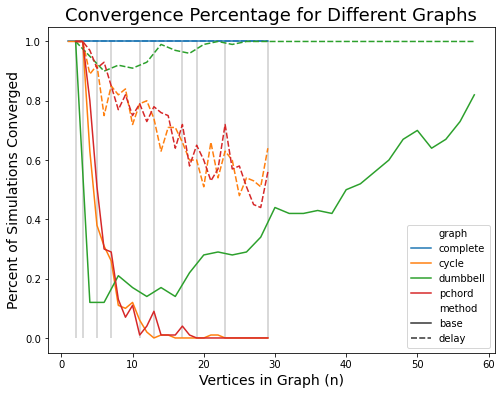

In [319]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.lineplot(data = data_ag[data_ag['method'] != "constrained"], x = 'n', y = 'percent_converged', hue = 'graph', style = 'method')
plt.vlines([2,3,5, 7, 11, 13, 17, 19, 23, 29], ymin = 0, ymax = 1, alpha = .2)

plt.title("Convergence Percentage for Different Graphs", fontsize = 18)
plt.xlabel("Vertices in Graph (n)", fontsize = 14)
plt.ylabel("Percent of Simulations Converged", fontsize = 14)

# plt.savefig('convergence_percentage_graphs.png')

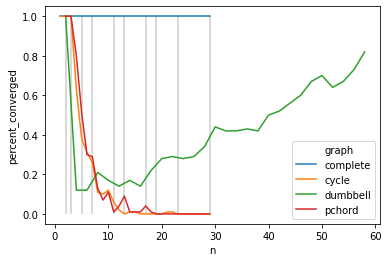

In [64]:
sns.lineplot(data = data_ag[data_ag['prc'] == 'x'], x = 'n', y = 'percent_converged', hue = 'graph')
plt.vlines([2,3,5, 7, 11, 13, 17, 19, 23, 29], ymin = 0, ymax = 1, alpha = .2)

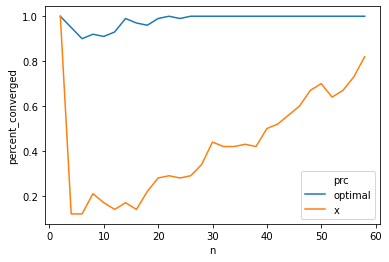

In [65]:
sns.lineplot(data = data_ag[data_ag['graph'] == 'dumbbell'], x = 'n', y = 'percent_converged', hue = 'prc')

In [160]:
# given a graph's adjacency matrix, calculate the 2nd smallest eigenvalue of its laplacian
import graphs
from importlib import reload # reload 
reload(graphs)
g = graphs.generate_cycle(15)

def lambda2(A):
    degrees = np.sum(A, axis = -1)
    D = np.diag(degrees)
    L = D - A
    eigvals, eigvecs = np.linalg.eig(L)
    eigvals.sort()
    if len(eigvals) >= 2:
        if eigvals[1].imag > .001:
            print("nontrivial complex component to eval")
        return eigvals[1].real
    else:
        return 0

def get_graph_fn(string):
    if string == "cycle":
        return graphs.generate_cycle
    elif string == "complete":
        return graphs.generate_complete
    elif string == "dumbbell":
        return graphs.generate_dumbbell
    elif string == "pchord":
        return graphs.generate_pchord
    
def match_lambda2(graph_desc, nn):
    n = nn // 2 if graph_desc == "dumbbell" else nn
    A = get_graph_fn(graph_desc)(n)
    return lambda2(A)
    

In [111]:
match_lambda2("cycle", 15)

[-4.10528340e-16  1.72909085e-01  1.72909085e-01  6.61738787e-01
  6.61738787e-01  1.38196601e+00  1.38196601e+00  2.20905693e+00
  2.20905693e+00  3.00000000e+00  3.00000000e+00  3.61803399e+00
  3.61803399e+00  3.95629520e+00  3.95629520e+00]


0.17290908471479818

In [113]:
lambda2(g)

[-4.10528340e-16  1.72909085e-01  1.72909085e-01  6.61738787e-01
  6.61738787e-01  1.38196601e+00  1.38196601e+00  2.20905693e+00
  2.20905693e+00  3.00000000e+00  3.00000000e+00  3.61803399e+00
  3.61803399e+00  3.95629520e+00  3.95629520e+00]


0.17290908471479818

In [161]:
def get_lambda2(row):
#     print(row['graph'])
    return match_lambda2(row['graph'], row['n'])
        

In [185]:
data['lambda2'] = data.apply(lambda row: get_lambda2(row), axis=1)

In [216]:
data_ag = data.groupby(['n', 'graph', 'prc', 'delay', 'lambda2']).agg(
    converged_sum = ('converged', np.sum),
    converged_count = ('converged', "count")
    )
data_ag["percent_converged"] = data_ag["converged_sum"]/data_ag["converged_count"]
data_ag = data_ag.reset_index()
data_ag

,n,graph,prc,delay,lambda2,converged_sum,converged_count,percent_converged
0,1,complete,x,0,0.000000,100,100,1.00
1,1,cycle,x,0,0.000000,100,100,1.00
2,2,complete,optimal,5,2.000000,100,100,1.00
3,2,complete,x,0,2.000000,200,200,1.00
4,2,cycle,optimal,5,2.000000,100,100,1.00
...,...,...,...,...,...,...,...,...
237,54,dumbbell,x,0,0.069130,67,100,0.67
238,56,dumbbell,optimal,5,0.066815,100,100,1.00
239,56,dumbbell,x,0,0.066815,73,100,0.73
240,58,dumbbell,optimal,5,0.064651,100,100,1.00


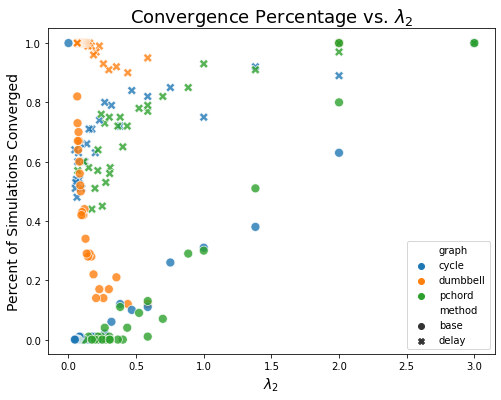

In [329]:
# sns.scatterplot(data = data_ag, x = 'lambda2', y = 'percent_converged', hue = 'graph', alpha = .4)

fig, ax = plt.subplots(figsize=(8, 6))

sns.scatterplot(data = data_ag[data_ag['graph'] != "complete"], x = 'lambda2', y = 'percent_converged', 
                hue = 'graph', 
                style = 'method', 
                alpha = .8,
                s = 80)

plt.title(r"Convergence Percentage vs. $\lambda_2$", fontsize = 18)
plt.xlabel(r'$\lambda_2$', fontsize = 14)
plt.ylabel("Percent of Simulations Converged", fontsize = 14)

plt.savefig('convergence_lambda2.png')

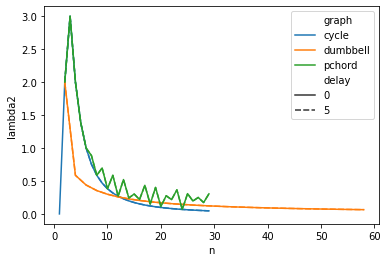

In [330]:
sns.lineplot(data = data_ag[data_ag['graph'] != "complete"], x = 'n', y = 'lambda2', hue = 'graph', style = 'delay')

In [188]:
def label_method(row):
    if row["delay"] == 5:
        return "delay"
    elif row["initial_positions"] == "constrained_first_half":
        return "constrained"
    else:
        return "base"

In [241]:
data['method'] = data.apply(lambda row: label_method(row), axis=1)

In [240]:
# data.to_csv("combined_with_lambda2.csv")

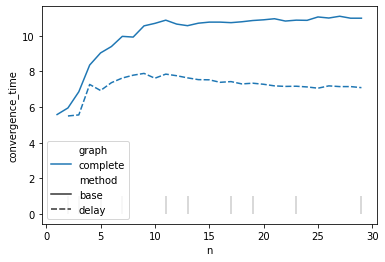

In [332]:
sns.lineplot(data = data_ag[data_ag["graph"] == 'complete'], x = 'n', y = 'convergence_time', hue = 'graph', style = 'method')
# plt.yscale('log')
plt.vlines([2,3,5, 7, 11, 13, 17, 19, 23, 29], ymin = 0, ymax = 1, alpha = .2)

In [6]:
cc_ag = clique_cycle_data.groupby(['n', 'c', 'graph', 'prc', 'delay', 'lambda2']).agg(
    converged_sum = ('converged', np.sum),
    converged_count = ('converged', "count"),
    convergence_time = ('steps_to_converge', "mean"),
    repeat_time = ('steps_to_repeat', "mean"),
    )
cc_ag["percent_converged"] = cc_ag["converged_sum"]/cc_ag["converged_count"]
cc_ag = cc_ag.reset_index()
cc_ag = cc_ag[cc_ag["n"] > 0]
cc_ag

,n,c,graph,prc,delay,lambda2,converged_sum,converged_count,convergence_time,repeat_time,percent_converged
0,10,1,dumbbell,x,5,10.000000,100,100,7.720000,NaN,1.00
1,10,2,dumbbell,x,5,0.343146,100,100,20.520000,NaN,1.00
2,10,3,dumbbell,x,5,0.255437,100,100,24.550000,NaN,1.00
3,10,4,dumbbell,x,5,0.169048,99,100,32.121212,37.000000,0.99
4,10,5,dumbbell,x,5,0.116291,98,100,37.387755,125.500000,0.98
5,10,6,dumbbell,x,5,0.083920,97,100,41.257732,106.666667,0.97
6,10,7,dumbbell,x,5,0.063083,96,100,44.197917,100.250000,0.96
7,10,8,dumbbell,x,5,0.049016,95,100,46.526316,165.000000,0.95
8,10,9,dumbbell,x,5,0.039120,94,100,52.106383,155.666667,0.94
9,10,10,dumbbell,x,5,0.031915,94,100,50.053191,233.333333,0.94


Text(0.5, 0, 'Cycle Size (c)')

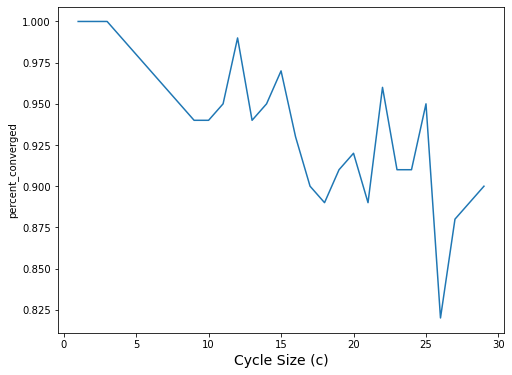

In [7]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.lineplot(data = cc_ag, x = 'c', y = 'percent_converged')
# sns.lineplot(data = data_ag[], x = 'c', y = 'percent_converged')

# plt.title("Convergence Percentage for Different Graphs", fontsize = 18)
plt.xlabel("Cycle Size (c)", fontsize = 14)
# plt.ylabel("Percent of Simulations Converged", fontsize = 14)

Text(0, 0.5, 'Percent of Simulations Converged')

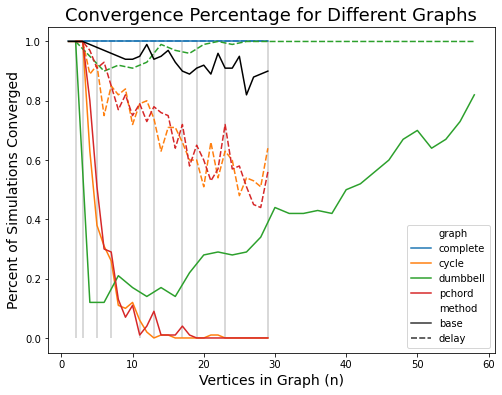

In [10]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.lineplot(data = data_ag[data_ag['method'] != "constrained"], x = 'n', y = 'percent_converged', hue = 'graph', style = 'method')
plt.vlines([2,3,5, 7, 11, 13, 17, 19, 23, 29], ymin = 0, ymax = 1, alpha = .2)

sns.lineplot(data = cc_ag, x = 'c', y = 'percent_converged', color = 'black')

plt.title("Convergence Percentage for Different Graphs", fontsize = 18)
plt.xlabel("Vertices in Graph (n)", fontsize = 14)
plt.ylabel("Percent of Simulations Converged", fontsize = 14)

